In [1]:
from pprint import pprint
from dotenv import load_dotenv
import os
load_dotenv()
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = os.getenv("OPENROUTER_BASE_URL", "https://openrouter.ai/api/v1")

In [26]:
qa_generation_prompt = """
You are an expert problem setter for comprehension and critical thinking. Your task is to generate questions based on the provided text passage.
Make sure the questions are clear, concise, and relevant to the content of the passage. Aim to create questions that encourage good reading comprehension and retention of facts.
Questions must be answerable directly from the passage without any external knowledge. Ensure that the questions cover different aspects of the passage.
Do not generate questions that cannot be answered using the information in the passage. Avoid overly complex or ambiguous questions, as well as yes/no questions.
Every question should focus on a specific detail or fact presented in the passage and should not require inference beyond the given text. 
Generate each question and answer pair in the following format:

Example Passage:
John Doe is a student at XYZ University, majoring in Computer Science. He has a keen interest in artificial intelligence and machine learning. In his free time, John enjoys hiking and photography.
Output:
Q: Where does John Doe study?
A: XYZ University
Q: What is John Doe's major?
A: Computer Science
Q: What are John's interests outside of academics?
A: Hiking and photography

Generate as many question and answer pairs as possible from the passage, following the format above.
Generate questions for the following passage: 
{passage}
"""

triplet_extraction_prompt = """
You are an expert information extractor. Your task is to extract key information from the question and answer pairs in the form of triplets (subject, relation, object).
Each triplet should represent a distinct piece of information conveyed in the Q&A pair. Ensure that the triplets are clear, concise, and accurately reflect the content of the Q&A.
If a Q&A pair does not provide sufficient information or is too vague to form a triplet, skip that pair.
Format the output as a JSON array of triplets, where each triplet is represented as an object with "subject", "relation", and "object" fields.
Example Q&A Pair:
Q: Where does John Doe study?
A: XYZ University
Q: What is John Doe's major?
A: Computer Science
Q: What are John's interests outside of academics?
A: Hiking and photography
Extracted Triplets:
[
  {{"subject": "John Doe", "relation": "studies at", "object": "XYZ University"}}
]
Extracted Triplets:
[
  {{"subject": "John Doe", "relation": "studies at", "object": "XYZ University"}},
  {{"subject": "John Doe", "relation": "has major", "object": "Computer Science"}},
  {{"subject": "John Doe", "relation": "interests", "object": "Hiking and photography"}}
]

Extract triplets for the following Q&A pairs:
{qa_pairs}
"""

In [27]:
from model.openai_model import OpenAIModel
from agent.core_agent import Agent

model = OpenAIModel(
    model_name="openai/gpt-4o-mini",
    base_url=OPENROUTER_BASE_URL,
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)
qa_agent = Agent(llm=model, prompt=qa_generation_prompt)
triplet_agent = Agent(llm=model, prompt=triplet_extraction_prompt)


In [30]:
from pathlib import Path
from random import sample
import json

data_path = Path("data/")

def format_to_json(triples: str) -> dict:
    if '```json' in triples:
        triples = triples.split('```json')[1].split('```')[0].strip()
        return json.loads(triples)
    else:
        return json.loads(triples)

text_file = data_path / "webnlg.txt"
lines = text_file.read_text().strip().split("\n")
print(f"Loaded {len(lines)} text passages.")

sample_passages = sample(lines, 3)

for passage in sample_passages:
    print("\nPassage:")
    print(passage)

    qa_pairs = qa_agent.run({"passage": passage})
    print("\nGenerated Q&A Pairs:")
    print(qa_pairs)

    triplets = triplet_agent.run({"qa_pairs": qa_pairs})
    # print("\nExtracted Triplets:")
    pprint(format_to_json(triplets))

Loaded 1165 text passages.

Passage:
Akeem Ayers made his debut for the Tennessee Titans and currently plays for the Los Angeles Rams.

Generated Q&A Pairs:
Q: For which team did Akeem Ayers make his debut?  
A: Tennessee Titans  

Q: Which team does Akeem Ayers currently play for?  
A: Los Angeles Rams  
[{'object': 'Tennessee Titans',
  'relation': 'made debut for',
  'subject': 'Akeem Ayers'},
 {'object': 'Los Angeles Rams',
  'relation': 'currently plays for',
  'subject': 'Akeem Ayers'}]

Passage:
11th Mississippi Infantry established in the year 2000 have a monument falls under the category of Contributing property located in Adams County, Pennsylvania. To the southeast of Adams County, Pennsylvania lies Carroll County, Maryland.

Generated Q&A Pairs:
Q: When was the 11th Mississippi Infantry established?  
A: In the year 2000  

Q: What type of property does the monument of the 11th Mississippi Infantry fall under?  
A: Contributing property  

Q: In which county is the monument

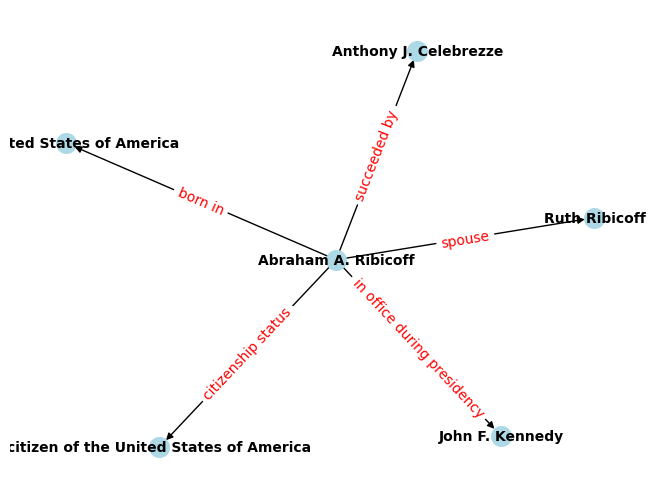

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()

for triplet in format_to_json(triplets):
    subject = triplet["subject"]
    relation = triplet["relation"]
    object_ = triplet["object"]
    G.add_edge(subject, object_, label=relation)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.show()

In [33]:
from tqdm import tqdm
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)


output_path = Path("output/webnlg/")
output_path.mkdir(parents=True, exist_ok=True)

all_triplets = []
generated_questions = []
error_info = []
for i, passage in tqdm(enumerate(lines), total=len(lines)):
    qa_pairs = qa_agent.run({"passage": passage})
    generated_questions.append(qa_pairs)
    triplets = triplet_agent.run({"qa_pairs": qa_pairs})
    try:
        triplet_data = format_to_json(triplets)
        all_triplets.extend(triplet_data)
    except Exception as e:
        print(f"Error processing triplets for passage {i}: {e}")
        error_info.append({"passage": passage, "error": str(e), "raw_output": triplets})
    if (i + 1) % 50 == 0:
        save_to_json(all_triplets, output_path / f"webnlg_triplets.json")
        with open(output_path / f"webnlg_questions.txt", 'w') as f:
            f.write("\n\n".join(generated_questions))
save_to_json(error_info, output_path / f"webnlg_errors.json")

100%|██████████| 1165/1165 [1:56:43<00:00,  6.01s/it] 


In [35]:
save_to_json(all_triplets, output_path / f"webnlg_triplets.json")
with open(output_path / f"webnlg_questions.txt", 'w') as f:
    f.write("\n\n".join(generated_questions))

In [44]:
with open(output_path / f"questions.txt", 'w') as f:
    f.write("\n#\n".join(generated_questions))
len(generated_questions)

1165

In [ ]:
all_triplets = []
triplets_text = []
for i, passage in tqdm(enumerate(generated_questions), total=len(generated_questions)):
    triplets = triplet_agent.run({"qa_pairs": passage})
    try:
        triplet_data = format_to_json(triplets)
        all_triplets.append(triplet_data)
    except Exception as e:
        print(f"Error processing triplets for passage {i}: {e}")
        error_info.append({"passage": passage, "error": str(e), "raw_output": triplets})
        triplets = triplet_agent.run({"qa_pairs": passage})
    t_json = format_to_json(triplets)
    all_triplets.append(t_json)
    triplets_text.append(t_json)



 24%|██▍       | 279/1165 [14:09<39:16,  2.66s/it]  

Error processing triplets for passage 279: Expecting value: line 1 column 1 (char 0)


 94%|█████████▍| 1093/1165 [54:46<04:04,  3.40s/it]

Error processing triplets for passage 1093: Expecting ':' delimiter: line 4 column 36 (char 190)


 94%|█████████▍| 1093/1165 [54:54<03:37,  3.01s/it]


JSONDecodeError: Expecting ':' delimiter: line 4 column 36 (char 190)

In [51]:
d_t = all_triplets[:]

In [ ]:
for i in tqdm(range(1094, len(generated_questions)), total=len(generated_questions)):
    passage = generated_questions[i]
    triplets = triplet_agent.run({"qa_pairs": passage})
    try:
        triplet_data = format_to_json(triplets)
        all_triplets.append(triplet_data)
    except Exception as e:
        print(f"Error processing triplets for passage {i}: {e}")
        error_info.append({"passage": passage, "error": str(e), "raw_output": triplets})
        triplets = triplet_agent.run({"qa_pairs": passage})
    t_json = format_to_json(triplets)
    all_triplets.append(t_json)
    triplets_text.append(t_json)

  6%|▌         | 71/1165 [03:29<53:45,  2.95s/it]  


In [54]:
passage = generated_questions[1093]
triplets = triplet_agent.run({"qa_pairs": passage})
# try:
triplet_data = format_to_json(triplets)
    # all_triplets.append(triplet_data)

JSONDecodeError: Expecting ':' delimiter: line 4 column 36 (char 190)

In [66]:
# tr = triplets.split('```json')[1].split('```')[0].strip()

# trip = json.loads(tr)
# trip
# remove newline characters from string
tr = triplets.replace('\n', ' ').split('```json')[1].split('```')[0].split('```')[0].strip()
# json.loads(tr)
import ast
# print(ast.literal_eval(tr))
tr = tr.replace('"relation", "is found in region"', '"relation": "is found in region"')
# print(ast.literal_eval(tr))
trip = json.loads(tr)

In [95]:
# place it in index 1093 of all_triplets
all_triplets.insert(1093*2, trip)
all_triplets.insert(1093*2+1, trip)
# triplets_text.insert(1093, trip)

In [70]:
print(triplets_text[1092])
print(lines[1092])
print(triplets_text[1093])
print(lines[1093])
print(triplets_text[1094])
print(lines[1094])

[{'subject': 'MotorSport Vision', 'relation': 'founded by', 'object': 'Jonathan Palmer'}]
MotorSport Vision was founded by Jonathan Palmer.
[{'subject': 'Bionico', 'relation': 'is a type of', 'object': 'dessert food'}, {'subject': 'Bionico', 'relation': 'is found in', 'object': 'Mexico'}, {'subject': 'Bionico', 'relation': 'is found in region', 'object': 'Jalisco'}, {'subject': 'another type of dessert', 'relation': 'is', 'object': 'a cookie'}, {'subject': 'Mexico', 'relation': 'has national currency', 'object': 'the peso'}, {'subject': 'local people of Mexico', 'relation': 'are called', 'object': 'Mexicans'}]
Bionico is a dessert food found in Mexico in the region of Jalisco. Another type of dessert is a cookie. In Mexico, the national currency is the peso and the local people are called Mexicans.
[{'subject': 'Grigory Neujmin', 'relation': 'born on', 'object': '1886-01-01'}, {'subject': 'Grigory Neujmin', 'relation': 'born in', 'object': 'Tbilisi'}, {'subject': 'Grigory Neujmin', 're

In [99]:
with open(output_path / f"triplets.txt", 'w') as f:
    # dump as list of lists
    for idx, triplet in enumerate(all_triplets):
        # convert each triplet to a list of lists
        if idx % 2 == 0:
            continue
        try:
            # might not have object key
            triplet_lines = [f"[{t['subject']}, {t['relation']}, {t.get('object', '')}]" for t in triplet]
        except Exception as e:
            print(f"Error processing triplet {triplet}: {e}")
            continue
        t_str = ""  
        for t in triplet:
            subject = t['subject'].replace("'", "\\'")
            relation = t['relation'].replace("'", "\\'")
            object_ = t['object'].replace("'", "\\'") if 'object' in t else ''
            t_str += f"['{subject}', '{relation}', '{object_}'], "
        f.write(f"[{t_str[:-2]}]\n")

In [94]:
print(len(triplets_text))

1165


In [50]:
print(triplets_text)

[[{'subject': 'Trane', 'relation': 'is located in', 'object': 'Swords, Dublin'}], [{'subject': 'Ciudad Ayala', 'relation': 'has population density', 'object': '1604.0'}, {'subject': 'Ciudad Ayala', 'relation': 'has total population', 'object': '1,777,539'}, {'subject': 'Ciudad Ayala', 'relation': 'has UTC offset', 'object': '-6'}, {'subject': 'Ciudad Ayala', 'relation': 'has government type', 'object': 'Council-manager government'}, {'subject': 'Ciudad Ayala', 'relation': 'has leader', 'object': 'City Manager'}], [{'subject': 'ALCO RS-3', 'relation': 'has length', 'object': '17068.8 millimeters'}, {'subject': 'ALCO RS-3', 'relation': 'has transmission type', 'object': 'Diesel-electric transmission'}], [{'subject': 'Alan B. Miller Hall', 'relation': 'located in', 'object': 'Virginia, USA'}, {'subject': 'Alan B. Miller Hall', 'relation': 'designed by', 'object': 'Robert A.M. Stern'}, {'subject': 'Alan B. Miller Hall', 'relation': 'address', 'object': '101 Ukrop Way'}, {'subject': 'Alan B

In [78]:
print(generated_questions[3])

Q: Where is Alan B. Miller Hall located?
A: Virginia, USA

Q: Who designed Alan B. Miller Hall?
A: Robert A.M. Stern

Q: What is the address of Alan B. Miller Hall?
A: 101 Ukrop Way

Q: Who are the current tenants of Alan B. Miller Hall?
A: The Mason School of Business


In [92]:
# save it in the triplet format necessary for evaluation
with open(output_path / f"triplets.txt", 'w') as f:
    for triplet in all_triplets:
        # print(triplet)
        if len(triplet) == 0:
            f.write("[]\n")
            continue
        t_str = ""  
        for t in triplet:
            t_str += f"['{t['subject']}', '{t['relation']}', '{t['object'] if 'object' in t else ''}'], "
        f.write(f"[{t_str[:-2]}]\n")

In [97]:
print(len(all_triplets))

2330


In [34]:
import numpy as np

def gaussian_kl_divergence(A, B, eps=1e-6):
    """
    Computes KL(N_A || N_B) where:
      A : numpy array of shape (n_A, d)
      B : numpy array of shape (n_B, d)
    The embeddings are approximated by Gaussians.
    """
    # Means
    mu_A = A.mean(axis=0)
    mu_B = B.mean(axis=0)

    # Covariances (regularize for numerical stability)
    cov_A = np.cov(A, rowvar=False) + eps * np.eye(A.shape[1])
    cov_B = np.cov(B, rowvar=False) + eps * np.eye(B.shape[1])

    # Inverse and determinant
    inv_cov_B = np.linalg.inv(cov_B)
    det_cov_A = np.linalg.det(cov_A)
    det_cov_B = np.linalg.det(cov_B)

    # Dimensionality
    d = A.shape[1]

    # KL divergence formula for Gaussians
    term_trace = np.trace(inv_cov_B @ cov_A)
    term_quad  = (mu_B - mu_A).T @ inv_cov_B @ (mu_B - mu_A)
    term_det   = np.log(det_cov_B / det_cov_A)

    kl = 0.5 * (term_trace + term_quad - d + term_det)
    return kl

A = np.random.randn(200, 128)
B = np.random.randn(150, 128)

kl_AB = gaussian_kl_divergence(A, B)
print(f"KL(N_A || N_B) = {kl_AB}")
kl_BA = gaussian_kl_divergence(B, A)
print(f"KL(N_B || N_A) = {kl_BA}")


KL(N_A || N_B) = 463.2992587086178
KL(N_B || N_A) = 141.27694387681566
